In [1]:
import os
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib
from tqdm import tqdm
from napatrackmater.Trackvector import (
    BROWNIAN_FEATURES
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
2024-12-09 17:51:31.364065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 17:51:31.651665: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 17:51:32.564018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.s

In [2]:
dataset_name = 'Second'
home_folder = '/home/debian/jz/'
channel = 'nuclei_'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

normalized_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}predicted_morpho_feature_attention_shallowest_litest.csv')
print(f'reading data from {normalized_dataframe}')
tracks_dataframe = pd.read_csv(normalized_dataframe)
save_dir = os.path.join(tracking_directory, f'{channel}phasespaces')
Path(save_dir).mkdir(exist_ok=True)
deltat = 10
class_map_gbr = {
        0: "Basal",
        1: "Radial",
        2: "Goblet"
    }

reading data from /home/debian/jz/Mari_Data_Oneat/Mari_Second_Dataset_Analysis/nuclei_membrane_tracking/dataframes/goblet_basal_dataframe_normalized_nuclei_predicted_morpho_feature_attention_shallowest_litest.csv


In [3]:
all_trackmate_ids = [trackid for trackid in tracks_dataframe['TrackMate Track ID'].unique()]
result_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
unique_time_points = tracks_dataframe['t'].unique()

for i, time_point in enumerate(unique_time_points):
    time_data = tracks_dataframe[tracks_dataframe['t'] == time_point]
    
    if i + 1 < len(unique_time_points):
        next_time_point = unique_time_points[i + 1]
        next_time_data = tracks_dataframe[tracks_dataframe['t'] == next_time_point]

        for cell_type in class_map_gbr.values():
            cell_type_data = time_data[time_data['Cell_Type'] == cell_type]
            

            if not cell_type_data.empty:
                if time_point not in result_dict[cell_type]:
                    result_dict[cell_type][time_point] = {}
                for trackmate_id in cell_type_data['TrackMate Track ID'].unique():
                    current_trackmate_id_data = cell_type_data[cell_type_data['TrackMate Track ID'] == trackmate_id]
                    for track_id in current_trackmate_id_data['Track ID'].unique():
                        track_features = current_trackmate_id_data[current_trackmate_id_data['Track ID'] == track_id][BROWNIAN_FEATURES].to_numpy()
                        
                        if not next_time_data.empty:
                            next_cell_type_data = next_time_data[next_time_data['TrackMate Track ID'] == trackmate_id]
                            next_track_features = next_cell_type_data[next_cell_type_data['Track ID'] == track_id][BROWNIAN_FEATURES].to_numpy()
                            if next_track_features.shape[0] > 0 :
                            
                                derivative_features = next_track_features[0,:] - track_features
                            

                                for feature_name in BROWNIAN_FEATURES:
                                    pair_key = f"{feature_name}"
                                    if derivative_features.shape[0] > 0:
                                        
                                        pairwise_values = np.stack(
                                            [track_features[:, BROWNIAN_FEATURES.index(feature_name)],
                                            derivative_features[:, BROWNIAN_FEATURES.index(feature_name)]],
                                            axis=1
                                        )

                                        if pair_key not in result_dict[cell_type][time_point]:
                                            result_dict[cell_type][time_point][pair_key] = []

                                        result_dict[cell_type][time_point][pair_key].append({
                                            'Track ID': int(track_id),  
                                            'Pairwise Values': pairwise_values
                                        })


In [4]:


def build_dataframe(result_dict):
    """Converts result_dict to a pandas DataFrame for plotting, including Track ID."""
    rows = []

    for cell_type, time_data in result_dict.items():
        for time_point, feature_dict in time_data.items():
            for feature_name, track_data in feature_dict.items():
                for track_entry in track_data:
                    track_id = track_entry['Track ID']
                    pairwise_array = track_entry['Pairwise Values']

                    for feature_value, derivative_value in pairwise_array:
                        rows.append({
                            'Cell Type': cell_type,
                            'Time Point': time_point,
                            'Feature phase space': feature_name,
                            'Track ID': track_id, 
                            'Feature Value': feature_value,
                            'Derivative Value': derivative_value
                        })

    df = pd.DataFrame(rows)
    return df




def plot_phasespace(df, title='phasespace',  dataset_name='dataset'):
    """Plots the phase space using seaborn's kdeplot for all time points in one plot per feature, with a color bar."""
    
    cmap = plt.cm.viridis
    norm = matplotlib.colors.Normalize(vmin=df['Time Point'].min(), vmax=df['Time Point'].max())

    for cell_type in df['Cell Type'].unique():
        cell_type_df = df[df['Cell Type'] == cell_type]
        
        for feature_name in cell_type_df['Feature phase space'].unique():
            phasespace_df = cell_type_df[cell_type_df['Feature phase space'] == feature_name]
            print(f"Plotting for {cell_type} and feature phase space {feature_name}")
            
            fig, ax = plt.subplots(figsize=(8, 10))

            for time_point in sorted(phasespace_df['Time Point'].unique()):
                time_df = phasespace_df[phasespace_df['Time Point'] == time_point]

                if len(time_df) < 2 or time_df['Feature Value'].nunique() < 2:
                    print(f"Skipping KDE for time {time_point} due to insufficient data.")
                    continue 

                color = cmap(norm(time_point))

                sns.kdeplot(
                    data=time_df,
                    x='Feature Value',
                    y='Derivative Value',
                    label=f"Time {time_point}",
                    alpha=0.5,
                    ax=ax,
                    color=color,
                    warn_singular=False
                )

            ax.set_xlabel(f'{feature_name}', fontsize=14)
            ax.set_ylabel(f'{feature_name}_derivative', fontsize=14)

            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([]) 
            cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
            cbar.set_label('Time Point', fontsize=14)

            ax.set_title(f"{title} - {cell_type} ({feature_name})", fontsize=16)
            ax.legend(title="Time Points", loc="upper right", fontsize=10)

          

            plot_filename = os.path.join(save_dir, f"{title}_{cell_type}_{feature_name}_{dataset_name}_phasespace.png")
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

          

def test_ergodicity(
    df, 
    feature_name='Radius', 
    error_tolerance=0.5, 
    time_delta=50, 
    max_failed_tracks=5
):
    """
    Tests the ergodicity of the system by comparing time averages and ensemble averages 
    for a given feature's value and its derivative over specified time intervals.
    """
    ergodicity_times = []
    max_diff_feature_global = -float('inf')
    min_diff_feature_global = float('inf')
    max_diff_derivative_global = -float('inf')
    min_diff_derivative_global = float('inf')

    for cell_type in df['Cell Type'].unique():
        cell_type_df = df[df['Cell Type'] == cell_type]

        total_time_points = len(cell_type_df['Time Point'].unique())
        time_points = sorted(cell_type_df['Time Point'].unique())

        for start_time in tqdm(range(0, total_time_points + 2 * time_delta, time_delta)):
            if start_time + time_delta >= total_time_points:
                start_time = total_time_points - time_delta

            end_time = min(start_time + time_delta, total_time_points)
            time_interval_points = time_points[start_time:end_time]

            interval_df = cell_type_df[cell_type_df['Time Point'].isin(time_interval_points)]

          
            time_averages = {}
            for track_id in interval_df['Track ID'].unique():
                track_df = interval_df[interval_df['Track ID'] == track_id]
                time_averages[track_id] = (
                    np.mean(track_df['Feature Value'].values / time_delta),
                    np.mean(track_df['Derivative Value'].values / time_delta)
                )

            # Compute ensemble averages for each time point
            ensemble_averages = {}
            for time_point in time_interval_points:
                time_df = interval_df[interval_df['Time Point'] == time_point]
                ensemble_averages[time_point] = (
                    np.mean(time_df['Feature Value'].values),
                    np.mean(time_df['Derivative Value'].values)
                )

            # Compare time averages and ensemble averages
            failed_tracks_count = 0
            for track_id, (time_avg_feature, time_avg_derivative) in time_averages.items():
                for time_point in time_interval_points:
                    ensemble_avg_feature, ensemble_avg_derivative = ensemble_averages[time_point]
                    diff_feature = abs(time_avg_feature - ensemble_avg_feature)
                    diff_derivative = abs(time_avg_derivative - ensemble_avg_derivative)

                    # Update global max/min differences
                    max_diff_feature_global = max(max_diff_feature_global, diff_feature)
                    min_diff_feature_global = min(min_diff_feature_global, diff_feature)
                    max_diff_derivative_global = max(max_diff_derivative_global, diff_derivative)
                    min_diff_derivative_global = min(min_diff_derivative_global, diff_derivative)

                    # Check if differences exceed tolerance
                    if diff_feature > error_tolerance or diff_derivative > error_tolerance:
                        failed_tracks_count += 1
                        break  # Stop testing this track if it fails
                if failed_tracks_count >= max_failed_tracks:
                    break  # Stop testing this time interval if too many tracks fail

            # Record ergodic time intervals if successful
            if failed_tracks_count < max_failed_tracks:
                ergodicity_times.append({
                    'Cell Type': cell_type,
                    'Feature': feature_name,
                    'Ergodic Time Interval': f"{start_time}-{end_time}"
                })

    # Summarize results
    if ergodicity_times:
        ergodicity_df = pd.DataFrame(ergodicity_times)
        print("Ergodicity Times:\n", ergodicity_df)
    else:
        print(f"Ergodicity was not reached within the specified intervals.")

    # Print global max/min differences
    print(f"Max difference for {feature_name} Value: {max_diff_feature_global}")
    print(f"Min difference for {feature_name} Value: {min_diff_feature_global}")
    print(f"Max difference for {feature_name} Derivative: {max_diff_derivative_global}")
    print(f"Min difference for {feature_name} Derivative: {min_diff_derivative_global}")





            

In [5]:
feature_dataframe = build_dataframe(result_dict)


In [12]:
test_ergodicity(feature_dataframe,error_tolerance=0.25, feature_name='Speed', time_delta=50, max_failed_tracks=5)

100%|██████████| 8/8 [00:08<00:00,  1.03s/it]

Ergodicity Times:
    Cell Type Feature Ergodic Time Interval
0      Basal   Speed               100-150
1      Basal   Speed               200-250
2      Basal   Speed               210-260
3      Basal   Speed               210-260
4      Basal   Speed               210-260
5     Radial   Speed               210-260
6     Radial   Speed               210-260
7     Radial   Speed               210-260
8     Goblet   Speed               200-250
9     Goblet   Speed               210-260
10    Goblet   Speed               210-260
11    Goblet   Speed               210-260
Max difference for Speed Value: 0.7326617573053593
Min difference for Speed Value: 3.5319217272199166e-08
Max difference for Speed Derivative: 0.5242046891150688
Min difference for Speed Derivative: 1.6536158050658003e-07


Plotting for Basal and feature phase space Radius


/tmp/ipykernel_1432158/2092625746.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Time Points", loc="upper right", fontsize=10)


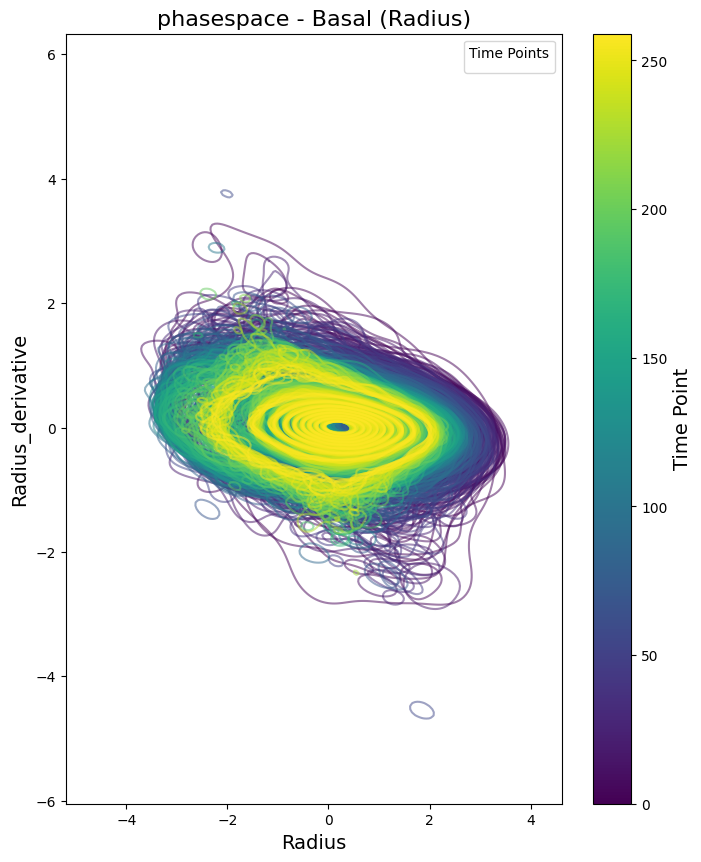

Plotting for Basal and feature phase space Eccentricity_Comp_First


/tmp/ipykernel_1432158/2092625746.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Time Points", loc="upper right", fontsize=10)


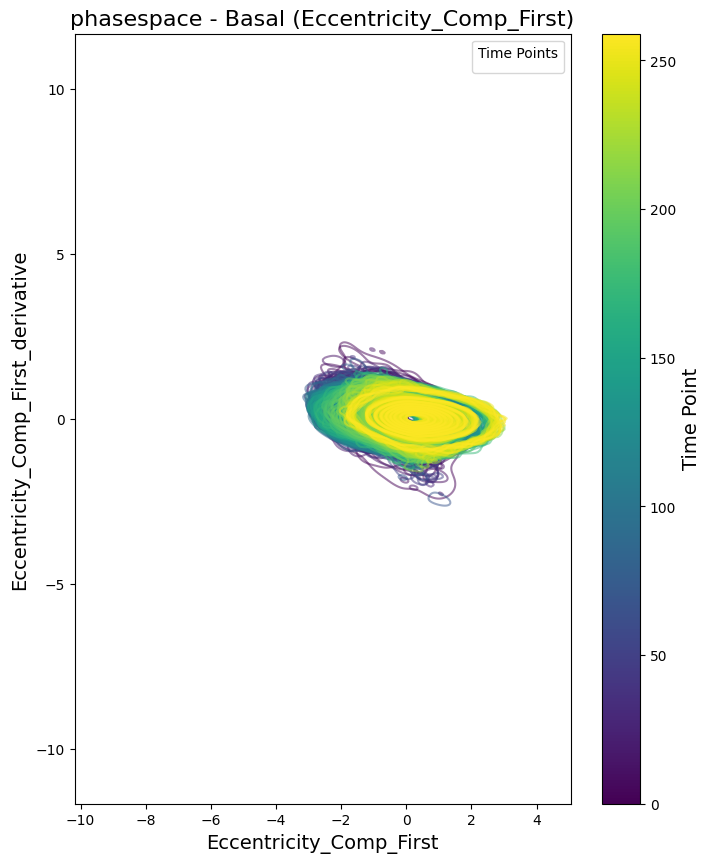

Plotting for Basal and feature phase space Eccentricity_Comp_Second


/tmp/ipykernel_1432158/2092625746.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Time Points", loc="upper right", fontsize=10)


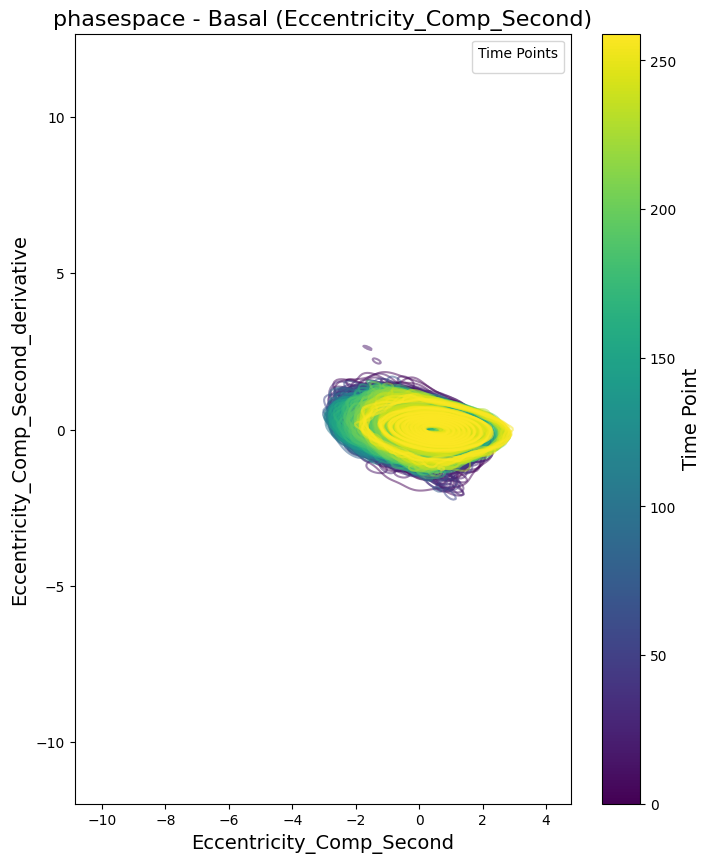

Plotting for Basal and feature phase space Eccentricity_Comp_Third


/tmp/ipykernel_1432158/2092625746.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Time Points", loc="upper right", fontsize=10)


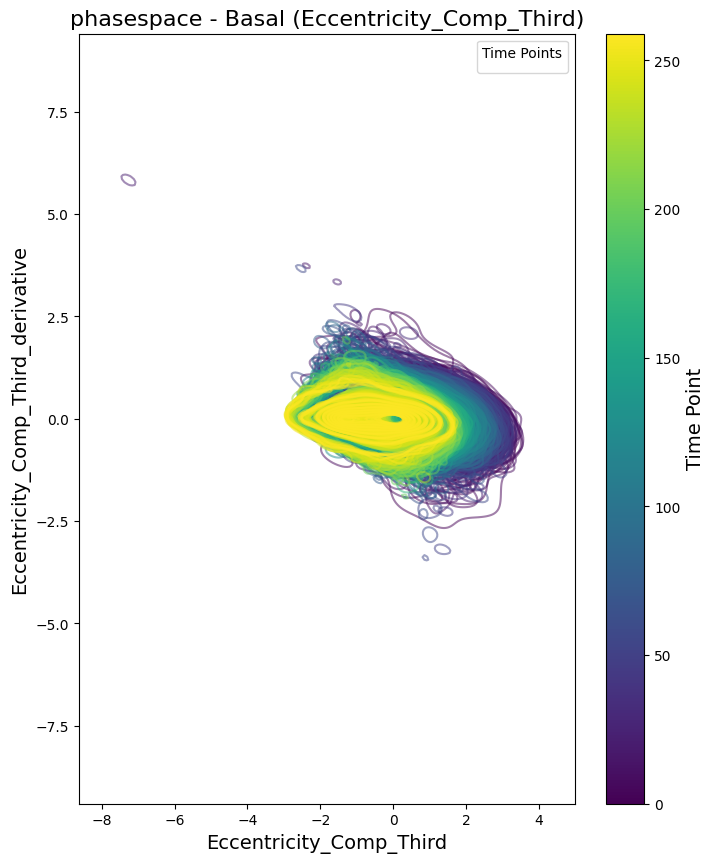

Plotting for Basal and feature phase space Surface_Area


/tmp/ipykernel_1432158/2092625746.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Time Points", loc="upper right", fontsize=10)


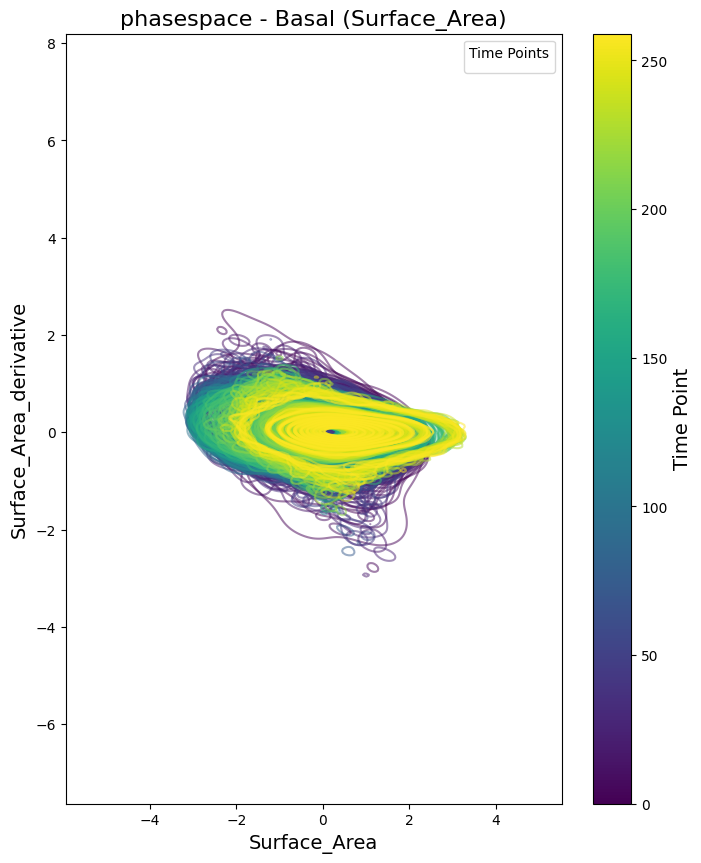

Plotting for Basal and feature phase space Speed
Skipping KDE for time 0.0 due to insufficient data.


/tmp/ipykernel_1432158/2092625746.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Time Points", loc="upper right", fontsize=10)


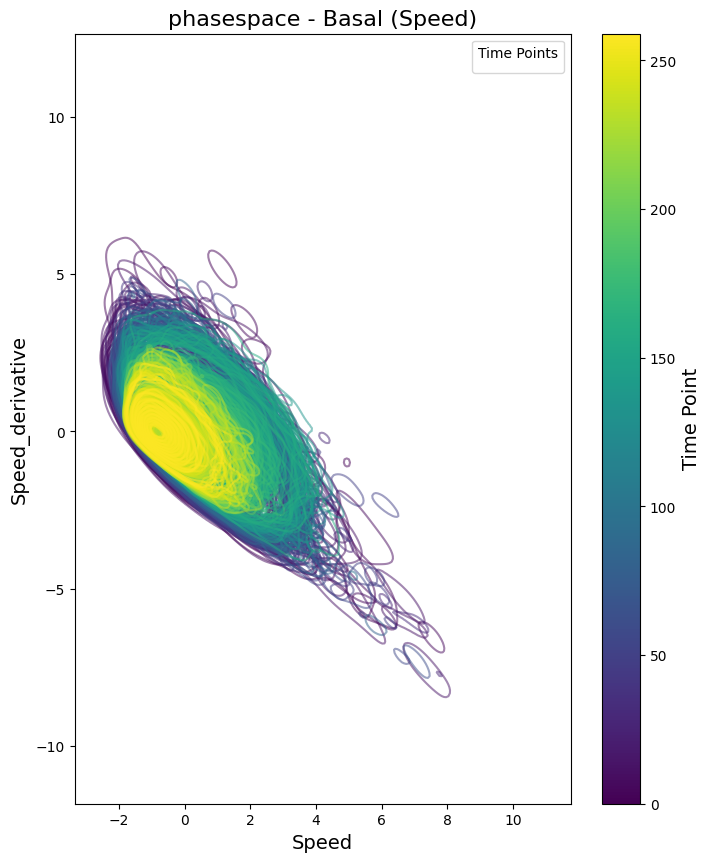

Plotting for Basal and feature phase space Acceleration
Skipping KDE for time 0.0 due to insufficient data.
Skipping KDE for time 1.0 due to insufficient data.


In [16]:

plot_phasespace(feature_dataframe)